In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from scipy.optimize import minimize_scalar

import nengo
import nengo_brainstorm as brd
from nengo_brainstorm.config import add_params
from nengolib.signal import nrmse

In [3]:
def go(dac_syn_lk=10, dt=0.001, length=1000, freq=10,
       radius=1, seed=0, n_neurons=64, syn_probe=nengo.Lowpass(0.01),
       solver=nengo.solvers.LstsqL2(reg=1e-3), function=lambda x: x,
       bounds=(0, 0.1), maxiter=100):
    
    u_array = nengo.processes.WhiteSignal(
        period=length*dt, high=freq, y0=0, seed=seed).run_steps(length, dt=dt)
    u_array *= radius / np.max(np.abs(u_array))

    with nengo.Network() as model:
        add_params(model)
        model.config[model].dac_syn_lk = dac_syn_lk
        
        u = nengo.Node(output=nengo.processes.PresentInput(u_array, dt))
        x = nengo.Ensemble(n_neurons=n_neurons, dimensions=1)
        
        nengo.Connection(u, x, synapse=None)  # synapse determined by brd
        
        p_spikes = nengo.Probe(x.neurons, 'spikes', synapse=None)

    with brd.Simulator(model, dt=dt, precompute_inputs=True) as sim:
        sim.run(length*dt)

    runs = []
    def objective_function(
            tau, verbose=False,
            a=syn_probe.filt(sim.data[p_spikes], y0=0, dt=dt)):
        y_ideal = syn_probe.filt(function(
            nengo.Lowpass(tau).filt(u_array, y0=0, dt=dt)), y0=0, dt=dt)
        d, _ = solver(a, y_ideal)
        y_hat = a.dot(d)
        e = nrmse(y_hat, target=y_ideal)

        if verbose:
            plt.figure()
            plt.title(r"$\tau = %f \mapsto NRMSE = %f$" % (tau, e))
            plt.plot(sim.trange(), u_array, label=r"$u$")
            plt.plot(sim.trange(), y_ideal, label=r"$y$")
            plt.plot(sim.trange(), y_hat, label=r"$\hat{y}$")
            plt.legend()
            plt.xlabel("Time (s)")
            plt.show()

        runs.append((tau, e))
        return e

    opt = minimize_scalar(
        objective_function, bounds=bounds, method='bounded',
        args=(False,), options={'maxiter': maxiter})

    return opt, runs

In [4]:
lks = list(range(0, 1024, 20))
r = []
for lk in lks:
    opt, runs = go(lk)
    print("dac_syn_lk = %s =>\n%s\Run Details: %s" % (lk, opt, runs))
    r.append((opt, runs))

HAL: clearing hardware state
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca2ba6470> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Computing pool stats
... computing stats
Gathering spikes for bias=-2
Gathering spikes for <Ensemble (unlabeled) at 0x755ca2ba6470> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Computing pool stats
... computing stats
Gathering spikes for bias=-1
Gathering spikes for <Ensemble (unlabeled) at 0x755ca2ba6470> neurons 0-64
HAL: doing logical mapping
mapping results writte

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
0 => 
     fun: 0.2332510460428455
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.024856478525262918
Details: [(0.03819660112501051, 0.2510141048179713), (0.06180339887498948, 0.2896965352544935), (0.02360679774997897, 0.23355167905307164), (0.014589803375031548, 0.2619036933152909), (0.02764742240742446, 0.23450327588665784), (0.024335011225574237, 0.23330161184563003), (0.024953341124998685, 0.23325278619252943), (0.024845224344474337, 0.233251064908267), (0.024856478525262918, 0.2332510460428455), (0.02485314482324843, 0.23325104681262507), (0.024859812227277407, 0.23325104932660315)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca09e3780> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL:

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
20 => 
     fun: 0.28690286560807765
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 0.02725316192337127
Details: [(0.03819660112501051, 0.30062053897721513), (0.06180339887498948, 0.3497174583990458), (0.02360679774997897, 0.2895161025425579), (0.01987854605060267, 0.2989999057564666), (0.02879238540485003, 0.28728772905624006), (0.027105555903062108, 0.2869067107311757), (0.02734624757645053, 0.2869043087655305), (0.027256495660983766, 0.2869028659230973), (0.02725316192337127, 0.28690286560807765), (0.02724982818580822, 0.28690286912276397)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca2bc2390> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: c

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
40 => 
     fun: 0.24836765466375546
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 0.031143103334690978
Details: [(0.03819660112501051, 0.25377401449092923), (0.06180339887498948, 0.29797961846694493), (0.02360679774997897, 0.257977648678105), (0.03344838640561742, 0.24904044482696977), (0.03200500305524541, 0.24846608588973396), (0.030670071656622905, 0.24839856217332668), (0.031135240117319437, 0.24836766310272912), (0.03114953910638159, 0.24836766028337315), (0.031143103334690978, 0.24836765466375546), (0.031139769539430772, 0.24836765618556877)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca0a8aac8> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
60 => 
     fun: 0.24590516009697544
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.031649504863626915
Details: [(0.03819660112501051, 0.2522388124540309), (0.06180339887498948, 0.3070985544639868), (0.02360679774997897, 0.26164025708964767), (0.03504775319769188, 0.24781730179793834), (0.03270111051264549, 0.24610432390677428), (0.029227392141628835, 0.2470982293678944), (0.03178373017494213, 0.2459085076804001), (0.031696299725934594, 0.2459055670955096), (0.0316460443718932, 0.24590516246477703), (0.031649504863626915, 0.24590516009697544), (0.031652838666398266, 0.2459051620508313)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca0a4bba8> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
80 => 
     fun: 0.24298548173342951
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 0.03128040400131505
Details: [(0.03819660112501051, 0.25018517624931186), (0.06180339887498948, 0.30516696272085375), (0.02360679774997897, 0.2575657815885249), (0.03430965078509845, 0.2445805629707972), (0.03229156365689931, 0.24317706483581042), (0.03054975955701279, 0.24309110639661813), (0.031277070204067794, 0.24298548192614985), (0.03129200902516956, 0.2429855146224284), (0.03128040400131505, 0.24298548173342951), (0.03128373779861175, 0.2429854858449145)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca07e4c50> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
100 => 
     fun: 0.24762445121541254
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.02471969117503048
Details: [(0.03819660112501051, 0.26870730743195187), (0.06180339887498948, 0.31667622085684066), (0.02360679774997897, 0.24788429142779836), (0.014589803375031548, 0.27587311788352636), (0.027183914258920437, 0.24873347507490817), (0.024296744320480946, 0.24766096099665247), (0.02478458039150259, 0.2476253090657732), (0.02471239185925254, 0.24762446052884898), (0.02471969117503048, 0.24762445121541254), (0.024716357475044876, 0.24762445280724146), (0.024723024875016087, 0.24762445409695047)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca072e630> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.tx

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
120 => 
     fun: 0.26221012646960284
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.030579587158263668
Details: [(0.03819660112501051, 0.26841381108658086), (0.06180339887498948, 0.3110232344168551), (0.02360679774997897, 0.27085531679286634), (0.032522122509722966, 0.26270447160557375), (0.03153737759764279, 0.26233461565394633), (0.03004649993975398, 0.2622507789795728), (0.027586752580687053, 0.26360636717677777), (0.030573979052413793, 0.262210130831697), (0.030588723375668828, 0.26221013827317907), (0.030579587158263668, 0.26221012646960284), (0.030582920945165577, 0.2622101280620894)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca08847b8> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
140 => 
     fun: 0.2703116910096406
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.028326872508891036
Details: [(0.03819660112501051, 0.28258474910335457), (0.06180339887498948, 0.3360310103770467), (0.02360679774997897, 0.2750599997518134), (0.02526753108286077, 0.27219611230353963), (0.029413407464065577, 0.27051654069265063), (0.03276828891277392, 0.2733402220006692), (0.02855908495934134, 0.27032132628911426), (0.0283927312145653, 0.27031246659513275), (0.028320811807737874, 0.2703116981745733), (0.028326872508891036, 0.2703116910096406), (0.028330206262379788, 0.2703116927243834)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca2bb3940> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
160 => 
     fun: 0.2570296487535753
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 0.028635073453894478
Details: [(0.03819660112501051, 0.2673521058889872), (0.06180339887498948, 0.31202349339565827), (0.02360679774997897, 0.26206727599906654), (0.02638041958472081, 0.2579417665090522), (0.029744675443772215, 0.2572235363024922), (0.028576852408062788, 0.2570302013227533), (0.02868110108887738, 0.2570300011665411), (0.028635073453894478, 0.2570296487535753), (0.02863173969583437, 0.25702965023783225), (0.028638407211954587, 0.25702965092373675)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca1329128> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
180 => 
     fun: 0.2748272018902544
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.03601203502530315
Details: [(0.03819660112501051, 0.27512474709294726), (0.06180339887498948, 0.29449069573331044), (0.02360679774997897, 0.2911168553838903), (0.04182487580136111, 0.2766830022367747), (0.037446414579743875, 0.27495896554425037), (0.03216015134204875, 0.2759769352932649), (0.03620869408531222, 0.2748297987587436), (0.03593816957915442, 0.27482756704248773), (0.03600870115787447, 0.27482720248267745), (0.03601203502530315, 0.2748272018902544), (0.036015368892781285, 0.27482720279569045)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca07c3cc0> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: p

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
200 => 
     fun: 0.243110620980995
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 0.030796917515234667
Details: [(0.03819660112501051, 0.2493006506786254), (0.06180339887498948, 0.29120926225946037), (0.02360679774997897, 0.2529932456809788), (0.03328472917710938, 0.2439526441119929), (0.03181438064650091, 0.24325957397118467), (0.03011335568989285, 0.24318181953615095), (0.030793583725158676, 0.24311062157621752), (0.030808722671986605, 0.24311064550549424), (0.030796917515234667, 0.243110620980995), (0.030800251305360106, 0.2431106236992314)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca055cdd8> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL:

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
220 => 
     fun: 0.23624549932160077
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 0.02865955968383282
Details: [(0.03819660112501051, 0.24505732964717847), (0.06180339887498948, 0.2822155273946047), (0.02360679774997897, 0.24088589128785362), (0.026662627491486682, 0.2368813973491565), (0.029868807549772555, 0.2364478997706748), (0.028625928535294675, 0.23624566898013188), (0.028711228371634877, 0.236245881930384), (0.02865955968383282, 0.23624549932160077), (0.028662893442256122, 0.23624550052802806), (0.02865622592540952, 0.23624550136195324)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca0a03208> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
H

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
240 => 
     fun: 0.288870945205941
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 0.02531088281687101
Details: [(0.03819660112501051, 0.30494941121994174), (0.06180339887498948, 0.34423286974001716), (0.02360679774997897, 0.28939273438327207), (0.014589803375031548, 0.3177922221613042), (0.027916370340561544, 0.2898884712222084), (0.025139999450543637, 0.2888758009783775), (0.025408447565858434, 0.2888725720620783), (0.025307549108166065, 0.2888709457137548), (0.02531088281687101, 0.288870945205941), (0.02531421652562541, 0.288870948419889)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca08be0b8> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: cl

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
260 => 
     fun: 0.2691941705454891
 message: 'Solution found.'
    nfev: 9
  status: 0
 success: True
       x: 0.02946913672482621
Details: [(0.03819660112501051, 0.27854584329446996), (0.06180339887498948, 0.3291419864438078), (0.02360679774997897, 0.27615316873147594), (0.029319288262280863, 0.2691978661919905), (0.030374813052198125, 0.2693272901128553), (0.029537440241768263, 0.2691949803043277), (0.02946913672482621, 0.2691941705454891), (0.02946580295439494, 0.2691941707986321), (0.029472470495257478, 0.26919417400276324)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca072d3c8> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
280 => 
     fun: 0.2757688368196013
 message: 'Solution found.'
    nfev: 12
  status: 0
 success: True
       x: 0.025606417393255816
Details: [(0.03819660112501051, 0.2945251797414816), (0.06180339887498948, 0.3448370398238174), (0.02360679774997897, 0.2766192883228383), (0.004972226968108753, 0.4192776823031414), (0.01648902507707025, 0.29851431766237413), (0.02780630041744095, 0.2766389734518058), (0.025686630707458476, 0.2757700920650535), (0.025694519752826852, 0.27577035118928744), (0.025612853295016082, 0.2757688445463244), (0.024846608260132103, 0.27588581994849726), (0.025606417393255816, 0.2757688368196013), (0.025603083680117936, 0.2757688392168114)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca04e16d8> neurons 0-64
HAL: doing logical mapping
map

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
300 => 
     fun: 0.25073345651315976
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 0.024554132687960778
Details: [(0.03819660112501051, 0.2851093856413973), (0.06180339887498948, 0.36435830878925796), (0.02360679774997897, 0.2510241367478474), (0.014589803375031548, 0.2915349863500359), (0.026863669269490964, 0.2522713582142978), (0.0241242971378142, 0.2507921888371998), (0.024604160734963704, 0.25073425070074706), (0.02454809351090785, 0.2507334666664941), (0.024554132687960778, 0.25073345651315976), (0.024557466385490754, 0.2507334607086093)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca60a7c50> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
320 => 
     fun: 0.2850686075170611
 message: 'Solution found.'
    nfev: 12
  status: 0
 success: True
       x: 0.028392267033507935
Details: [(0.03819660112501051, 0.2956552894667944), (0.06180339887498948, 0.3385466193384951), (0.02360679774997897, 0.28952985483651), (0.02516230061694968, 0.2869871522456088), (0.029569895028046106, 0.2852834360592673), (0.03286500354613056, 0.2877888107522378), (0.02866415442921938, 0.28508044930096993), (0.028474429034731286, 0.2850696899988168), (0.028383738630396515, 0.28506862037234776), (0.028392267033507935, 0.2850686075170611), (0.028395600787966643, 0.2850686089139498), (0.028388933279049226, 0.2850686097291433)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca0abb588> neurons 0-64
HAL: doing logical mapping
mapping

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
340 => 
     fun: 0.2594577988935589
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.03483412533545006
Details: [(0.03819660112501051, 0.2610058103040704), (0.06180339887498948, 0.3034905518904755), (0.02360679774997897, 0.28806232816089117), (0.04059405125258309, 0.2636116834857392), (0.03625669472511634, 0.25975587196326283), (0.03142486403479835, 0.2614959147463711), (0.035054699147071586, 0.25946535453471903), (0.03471267392861218, 0.25946005377243475), (0.0348307914854926, 0.259457799472689), (0.03483412533545006, 0.2594577988935589), (0.03483745918545696, 0.25945780175989713)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca07c0dd8> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: progr

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
360 => 
     fun: 0.2628608148492077
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.030320185336359155
Details: [(0.03819660112501051, 0.27037488201396287), (0.06180339887498948, 0.31670602553742294), (0.02360679774997897, 0.27217487926494177), (0.03203124670353146, 0.26330758327547), (0.03131100195340467, 0.26301471570357854), (0.029778498002345517, 0.2629094907282216), (0.0274211182743178, 0.26438070289541454), (0.030315908648181518, 0.26286081774225245), (0.030330203269703156, 0.2628608313565881), (0.030320185336359155, 0.2628608148492077), (0.030323519119413514, 0.2628608167203671)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca040f588> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
380 => 
     fun: 0.24678118018832246
 message: 'Solution found.'
    nfev: 12
  status: 0
 success: True
       x: 0.0283314771126589
Details: [(0.03819660112501051, 0.25882306914260245), (0.06180339887498948, 0.30807504168028127), (0.02360679774997897, 0.2516154598411146), (0.024976494110223478, 0.24910353830375623), (0.029498968154753044, 0.2470182234186797), (0.032821168327719696, 0.24986060692104917), (0.028611338208539703, 0.24679524636591227), (0.028414212614258638, 0.24678241077919322), (0.028322996167621906, 0.24678119446648544), (0.0283314771126589, 0.24678118018832246), (0.028334810866215948, 0.24678118174699426), (0.028328143359101852, 0.24678118267587057)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca02afef0> neurons 0-64
HAL: doing logical mappi

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
400 => 
     fun: 0.2500602807522058
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.03161524318896128
Details: [(0.03819660112501051, 0.2552241898762562), (0.06180339887498948, 0.3033503216066253), (0.02360679774997897, 0.26202937996763787), (0.03445770274729091, 0.251146646636352), (0.03252700834410706, 0.25017914671470015), (0.031082416350739946, 0.2501027668985322), (0.03160564435851098, 0.25006029435597293), (0.03162300287830799, 0.25006028957842796), (0.03161524318896128, 0.2500602807522058), (0.03161857699122445, 0.2500602823735878), (0.031611909386698105, 0.2500602824020297)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca08be3c8> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: prog

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
420 => 
     fun: 0.2711743705207012
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 0.02864531704057485
Details: [(0.03819660112501051, 0.2788319767283662), (0.06180339887498948, 0.3110592189492792), (0.02360679774997897, 0.275100250483028), (0.026498481291515896, 0.271806514343718), (0.029829118312903843, 0.27134124888476746), (0.028598690867052932, 0.27117464419687015), (0.028697037702624953, 0.27117470385434206), (0.02864531704057485, 0.2711743705207012), (0.028648650798786895, 0.2711743718508314), (0.028641983282362803, 0.2711743719744249)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca1359630> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
440 => 
     fun: 0.26562833838488586
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.03195674428388773
Details: [(0.03819660112501051, 0.2689081103332239), (0.06180339887498948, 0.29870993600548773), (0.02360679774997897, 0.275907485031274), (0.03616083092214666, 0.26723894652987457), (0.03321873501569002, 0.26579106785128687), (0.029547301677920128, 0.266313011553893), (0.032124165668334134, 0.2656313220467482), (0.03201878102698393, 0.2656287482657273), (0.031950892963605676, 0.2656283422826789), (0.03195674428388773, 0.26562833838488586), (0.031960078091216176, 0.2656283394522679)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca09453c8> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: pr

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
460 => 
     fun: 0.24391150618383498
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.03012355736084326
Details: [(0.03819660112501051, 0.2506255006469601), (0.06180339887498948, 0.2916073532442484), (0.02360679774997897, 0.25130173149143686), (0.03139834060632812, 0.2441260541016014), (0.031081835257303132, 0.24403415330537462), (0.029688414412432355, 0.2439381059628542), (0.02736544355392286, 0.24507334901903866), (0.03011898465024206, 0.24391150904400316), (0.030131229606484473, 0.2439115143757458), (0.03012355736084326, 0.24391150618383498), (0.030126891140981153, 0.2439115077440011)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca048cf28> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL:

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
480 => 
     fun: 0.2685177646956788
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.024560042721626277
Details: [(0.03819660112501051, 0.30014058846862923), (0.06180339887498948, 0.3690370472097535), (0.02360679774997897, 0.26880431196080645), (0.014589803375031548, 0.31067211914785914), (0.02716860219987925, 0.2703734048176687), (0.02396491685427712, 0.2686277522625253), (0.02463180818089162, 0.26851935904246765), (0.024550416945320536, 0.26851778834386236), (0.024560042721626277, 0.2685177646956788), (0.024556709024008642, 0.26851776650761866), (0.024563376419243912, 0.2685177696387554)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca0207ba8> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HA

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
500 => 
     fun: 0.2749805623360953
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.030434866615980136
Details: [(0.03819660112501051, 0.28000132562340874), (0.06180339887498948, 0.31194844950889156), (0.02360679774997897, 0.2817709810302392), (0.03247264443184053, 0.275411345936622), (0.03148412650669166, 0.27509926270590435), (0.02979896774711146, 0.27502703120782024), (0.027433769272324188, 0.2761154115244853), (0.030431532831274227, 0.2749805633581291), (0.030447613988776167, 0.27498058142486825), (0.030434866615980136, 0.2749805623360953), (0.030438200400735492, 0.2749805638086068)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca0804c88> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL:

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
520 => 
     fun: 0.2363865126415745
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.035709229325745204
Details: [(0.03819660112501051, 0.23708971258908804), (0.06180339887498948, 0.2720521794062991), (0.02360679774997897, 0.26303714386481114), (0.04132221088733384, 0.23959722392879657), (0.03700587384495869, 0.23658579585134085), (0.031887882194522654, 0.2384448570173649), (0.03590380924077239, 0.23639120783304865), (0.035634129642541756, 0.23638719771821076), (0.035705895462807856, 0.2363865133507905), (0.035709229325745204, 0.2363865126415745), (0.035712563188732005, 0.23638651468459304)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca095a198> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
H

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
540 => 
     fun: 0.25386199503403856
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 0.023588862992157678
Details: [(0.03819660112501051, 0.28605597525600296), (0.06180339887498948, 0.35424532232355294), (0.02360679774997897, 0.2538620784847746), (0.014589803375031548, 0.2812808575847788), (0.02593820308711783, 0.2551821033977637), (0.023881813661666057, 0.253884086197658), (0.023575064990753163, 0.253862044695061), (0.023588862992157678, 0.25386199503403856), (0.02359219667537039, 0.2538619978951532), (0.023585529308944964, 0.25386199795389947)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca0a71d30> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
560 => 
     fun: 0.2413386180276534
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.026349643538368453
Details: [(0.03819660112501051, 0.2606711624625871), (0.06180339887498948, 0.31680562874692225), (0.02360679774997897, 0.24319282190101324), (0.011510874691385849, 0.31515608878530016), (0.028665277138275706, 0.24242530498743015), (0.026671772513494185, 0.24136130392092692), (0.026475257124013666, 0.2413420741034398), (0.026327687689191043, 0.24133873101125622), (0.026349643538368453, 0.2413386180276534), (0.02635297726253016, 0.24133861962014289), (0.026346309814206745, 0.24133862137430184)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca0264828> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.tx

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
580 => 
     fun: 0.2754623419373309
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.02352259565022868
Details: [(0.03819660112501051, 0.2956736835766335), (0.06180339887498948, 0.3337022344482584), (0.02360679774997897, 0.27546363034927446), (0.014589803375031548, 0.2967875639500558), (0.026541716538872343, 0.27691495990817916), (0.0218389918244838, 0.2760248607337177), (0.0236422480401781, 0.2754649442727373), (0.023530265258748517, 0.2754623519761418), (0.02352259565022868, 0.2754623419373309), (0.02352592933245849, 0.27546234364811756), (0.02351926196799887, 0.2754623443076861)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca0a03748> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: progr

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
600 => 
     fun: 0.2528877776603779
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 0.025029779214027204
Details: [(0.03819660112501051, 0.2711771541513365), (0.06180339887498948, 0.3189934441328296), (0.02360679774997897, 0.2532659590288817), (0.014589803375031548, 0.2809922240575184), (0.02753381529628907, 0.25389057453259484), (0.02477675118845096, 0.25289916886568065), (0.025106319446006442, 0.25288881941519653), (0.02502499629127671, 0.25288778107993154), (0.025029779214027204, 0.2528877776603779), (0.02503311291861216, 0.25288778005728985)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca0698b38> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
620 => 
     fun: 0.2441821591021104
 message: 'Solution found.'
    nfev: 12
  status: 0
 success: True
       x: 0.02435141885012996
Details: [(0.03819660112501051, 0.28283230286654587), (0.06180339887498948, 0.36056304983101467), (0.02360679774997897, 0.24438948357068027), (0.014589803375031548, 0.2892802415610238), (0.026816663708142698, 0.2461908165839962), (0.023671924382329644, 0.24435436109588773), (0.02440990677178359, 0.24418343047664767), (0.025329206118813202, 0.24451797107634435), (0.02434320597635433, 0.2441821797534776), (0.02435141885012996, 0.2441821591021104), (0.024348085155606713, 0.24418216155673061), (0.024354752544653205, 0.24418216474453164)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca04e1ac8> neurons 0-64
HAL: doing logical mapping


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
640 => 
     fun: 0.22459068102397084
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 0.02497768180069384
Details: [(0.03819660112501051, 0.24955392343186852), (0.06180339887498948, 0.3101223577935453), (0.02360679774997897, 0.22506522379142507), (0.014589803375031548, 0.25995385948824123), (0.027330523650329144, 0.2258074956581751), (0.02473648139387991, 0.22460475387334322), (0.025042687073348047, 0.2245917026415444), (0.024973424301085637, 0.22459068481310177), (0.02497768180069384, 0.22459068102397084), (0.024981015504506064, 0.22459068413828287)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca0207a90> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
660 => 
     fun: 0.2801825016484006
 message: 'Solution found.'
    nfev: 12
  status: 0
 success: True
       x: 0.02765400979759824
Details: [(0.03819660112501051, 0.29330972041710446), (0.06180339887498948, 0.3412054482710934), (0.02360679774997897, 0.2835380125774687), (0.021490307188924043, 0.28853458603052407), (0.02905561992253171, 0.28051196746216916), (0.03254716405135473, 0.28369717289604995), (0.028022756959485657, 0.28020614719061226), (0.02777136612799325, 0.2801849000853216), (0.027640545992146073, 0.2801825369940749), (0.02765400979759824, 0.2801825016484006), (0.027657343541106827, 0.2801825028107636), (0.027650676054089655, 0.2801825044198253)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755c91ddc198> neurons 0-64
HAL: doing logical mapping
mapp

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
680 => 
     fun: 0.2561728613051001
 message: 'Solution found.'
    nfev: 12
  status: 0
 success: True
       x: 0.03233736347879691
Details: [(0.03819660112501051, 0.25895705586313184), (0.06180339887498948, 0.2882742967112243), (0.02360679774997897, 0.2671039121283516), (0.03682539003160287, 0.2578929112596238), (0.033667314130426625, 0.25634331094682283), (0.02982453881747069, 0.25688064256715276), (0.03252222343715788, 0.25617629771209227), (0.03240613003290686, 0.25617333712454887), (0.03233055607441467, 0.2561728663062528), (0.03233736347879691, 0.2561728613051001), (0.03234069729177086, 0.2561728622887512), (0.032334029665822966, 0.25617286257818656)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca095af60> neurons 0-64
HAL: doing logical mapping
mappin

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
700 => 
     fun: 0.25409926103598907
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 0.022907246452033292
Details: [(0.03819660112501051, 0.2831114665186256), (0.06180339887498948, 0.3418302724241475), (0.02360679774997897, 0.25420409330310845), (0.014589803375031548, 0.2737125138359423), (0.025259393434813388, 0.2552144397781417), (0.0232577211498969, 0.2541259315410668), (0.02285388324196721, 0.25409987879987594), (0.02290343855376946, 0.2540992636318954), (0.022907246452033292, 0.25409926103598907), (0.022910580125136, 0.25409926398705024)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca044af28> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: c

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
720 => 
     fun: 0.210726150056277
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 0.022662820096323165
Details: [(0.03819660112501051, 0.2541018208889063), (0.06180339887498948, 0.32676661355330333), (0.02360679774997897, 0.21103269530951405), (0.014589803375031548, 0.240435629432907), (0.025293367252335525, 0.21294042012397305), (0.023071758700204982, 0.21078507839344623), (0.022570069514301374, 0.21072917823608792), (0.0226565378703419, 0.21072616058396473), (0.022662820096323165, 0.210726150056277), (0.022666153765800442, 0.21072615590855912)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca07bbba8> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HA

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
740 => 
     fun: 0.2762573943755077
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 0.02416628768774183
Details: [(0.03819660112501051, 0.299345972696418), (0.06180339887498948, 0.35342483159104937), (0.02360679774997897, 0.2763215526296889), (0.014589803375031548, 0.30173233679387723), (0.026664613378723886, 0.2773973701635722), (0.023481430580543007, 0.2763540147821101), (0.02421887982058686, 0.27625795984983803), (0.024159928296292852, 0.2762574012221903), (0.02416628768774183, 0.2762573943755077), (0.024169621379519137, 0.2762573972823451)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca0945048> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
760 => 
     fun: 0.2727493649744399
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.030061190174701168
Details: [(0.03819660112501051, 0.27799296801308465), (0.06180339887498948, 0.30904011469130377), (0.02360679774997897, 0.2784253941194448), (0.03132261399519663, 0.27291230833475794), (0.0310504393773177, 0.272850611262303), (0.02960592096550047, 0.2727719994993389), (0.027314459799869815, 0.27364702709949584), (0.03005701143422907, 0.2727493668152219), (0.03006973762672466, 0.2727493728866094), (0.030061190174701168, 0.2727493649744399), (0.030064523953914006, 0.27274936619504847)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca0698a90> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: pr

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
780 => 
     fun: 0.2290744583053419
 message: 'Solution found.'
    nfev: 12
  status: 0
 success: True
       x: 0.0261353872172791
Details: [(0.03819660112501051, 0.2495645876548153), (0.06180339887498948, 0.30622102366390147), (0.02360679774997897, 0.23071752551557692), (0.008639526397350994, 0.34213147950215644), (0.017889808812117696, 0.25028059697237576), (0.02811915453597286, 0.22991800533942777), (0.026470733450306996, 0.22910018099436197), (0.026239804771628333, 0.2290769578005719), (0.0261163737793062, 0.22907454718678796), (0.0261353872172791, 0.2290744583053419), (0.02613872093826287, 0.22907446006128612), (0.02613205349629533, 0.22907446171963924)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca01e4e48> neurons 0-64
HAL: doing logical mapping
mapp

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
800 => 
     fun: 0.24711945249961098
 message: 'Solution found.'
    nfev: 12
  status: 0
 success: True
       x: 0.02740978162568964
Details: [(0.03819660112501051, 0.25929547136396935), (0.06180339887498948, 0.3026194993147017), (0.02360679774997897, 0.249844145502203), (0.020482619740089376, 0.2572784987294548), (0.02900649329193892, 0.24750567787551847), (0.03251680212389562, 0.25054489094323595), (0.02779204808017947, 0.24714263472639358), (0.027544688365015266, 0.2471223450217503), (0.027391978492038872, 0.2471195087481028), (0.02740978162568964, 0.24711945249961098), (0.027413115365575735, 0.24711945337886848), (0.027406447885803546, 0.247119455218112)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca04887f0> neurons 0-64
HAL: doing logical mapping
mapp

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
820 => 
     fun: 0.27915878556575635
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.02799792189561221
Details: [(0.03819660112501051, 0.2892115583604244), (0.06180339887498948, 0.3268411740074515), (0.02360679774997897, 0.28256803492742255), (0.023264241321541073, 0.28317582730870944), (0.0293768984827235, 0.279424620867905), (0.032745725121409885, 0.28188787545680005), (0.028442788507239677, 0.2791877495599359), (0.02776755686432037, 0.2791665491971903), (0.027991462626594996, 0.27915878759208634), (0.02799792189561221, 0.27915878556575635), (0.02800125564422184, 0.27915878934072924)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca1329278> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
840 => 
     fun: 0.25522104169960436
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.03585381179148007
Details: [(0.03819660112501051, 0.25580214357334813), (0.06180339887498948, 0.2877971067496324), (0.02360679774997897, 0.2811804756472396), (0.04163610146978317, 0.2583538493682852), (0.03722110771557985, 0.2554260265786007), (0.032020904042096725, 0.2571537736924153), (0.03605024577272255, 0.25522547441882565), (0.03577782611110575, 0.25522169738569767), (0.035850477926398214, 0.2552210425349652), (0.03585381179148007, 0.25522104169960436), (0.03585714565661137, 0.2552210434206188)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca0945240> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: pr

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
860 => 
     fun: 0.7896625195562252
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 0.018548479551691446
Details: [(0.03819660112501051, 0.7989982011451949), (0.06180339887498948, 0.8050747640098501), (0.02360679774997897, 0.7909211287462661), (0.014589803375031548, 0.7908292070670897), (0.018876873648721818, 0.7896691518391575), (0.019012438471475858, 0.7896756849397534), (0.018610365058391785, 0.789662755331108), (0.018544157031327592, 0.7896625209568843), (0.018548479551691446, 0.7896625195562252), (0.01855181316014319, 0.789662520073885)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca2bc2b70> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: cl

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
880 => 
     fun: 0.2315659140244171
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.02235881570198367
Details: [(0.03819660112501051, 0.26887664575992015), (0.06180339887498948, 0.33309565154959175), (0.02360679774997897, 0.23199785704470477), (0.014589803375031548, 0.2542212053639441), (0.02492540275397797, 0.23329373742884307), (0.022792880411395756, 0.2316200940437287), (0.022245638998845896, 0.2315695929093679), (0.022350356672123338, 0.23156592980026564), (0.02235881570198367, 0.2315659140244171), (0.022355482037015505, 0.23156591526385598), (0.022362149366951835, 0.23156591925725023)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca080f320> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
H

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
900 => 
     fun: 0.29054806728689236
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 0.02890791239704153
Details: [(0.03819660112501051, 0.2996071727483773), (0.06180339887498948, 0.3437026583005286), (0.02360679774997897, 0.2954731529932753), (0.02748656484167539, 0.2908585092986171), (0.029871428754550716, 0.29067919811995824), (0.02889036332715299, 0.29054811283521187), (0.02893174206871418, 0.29054814954301456), (0.02890791239704153, 0.29054806728689236), (0.028911246159148495, 0.29054806881594236), (0.028904578634934563, 0.2905480690070762)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca06a99e8> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
920 => 
     fun: 0.2380813375884684
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 0.02922223039808836
Details: [(0.03819660112501051, 0.24808933756934765), (0.06180339887498948, 0.2945216280244874), (0.02360679774997897, 0.24516409027053856), (0.028733906268216817, 0.23812499011055538), (0.030298787339147853, 0.2382811885350192), (0.029289571083717596, 0.23808216996493686), (0.029231585701796313, 0.23808135589559265), (0.02922223039808836, 0.2380813375884684), (0.029218896631319304, 0.23808133867670636), (0.029225564164857415, 0.23808134050097543)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca01e4d68> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
940 => 
     fun: 0.2411864861365471
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 0.0202344793796448
Details: [(0.03819660112501051, 0.29481108182728716), (0.06180339887498948, 0.3747545328368938), (0.02360679774997897, 0.24451394410849306), (0.014589803375031548, 0.253553200100788), (0.021757366396093672, 0.2419132907820727), (0.02058984767881014, 0.2412278779693651), (0.02009247818423431, 0.24119309241637546), (0.020228579093294154, 0.24118649421059785), (0.0202344793796448, 0.2411864861365471), (0.020237813013103966, 0.2411864917374034)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755c9198dc88> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: cl

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
960 => 
     fun: 0.232360961597059
 message: 'Solution found.'
    nfev: 12
  status: 0
 success: True
       x: 0.02601757745814585
Details: [(0.03819660112501051, 0.25355357552342234), (0.06180339887498948, 0.3096061449680442), (0.02360679774997897, 0.23385671849688464), (0.0057318765253912, 0.37732506206863997), (0.016779185388413335, 0.25932746721233835), (0.028056123398986506, 0.23326270485879574), (0.02628773772031845, 0.23237790064512295), (0.02611379987708897, 0.2323631136063429), (0.026001984114466723, 0.23236102167751949), (0.02601757745814585, 0.232360961597059), (0.02602091117738222, 0.2323609636001588), (0.02601424373890948, 0.23236096482191781)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca1329eb8> neurons 0-64
HAL: doing logical mapping
mappin

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
980 => 
     fun: 0.22989347933470022
 message: 'Solution found.'
    nfev: 12
  status: 0
 success: True
       x: 0.024238707474352108
Details: [(0.03819660112501051, 0.2607325471537359), (0.06180339887498948, 0.32739700656669135), (0.02360679774997897, 0.23000658571896576), (0.014589803375031548, 0.2638529194074682), (0.026659463579813143, 0.23137600101139416), (0.023571786328436435, 0.23001963621537677), (0.024289928815440707, 0.22989422027267414), (0.025195010557906503, 0.23013842628097775), (0.024231956386827087, 0.22989349001402765), (0.024238707474352108, 0.22989347933470022), (0.024242041167203573, 0.22989348338385207), (0.024235373781500643, 0.22989348144826485)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca04e1160> neurons 0-64
HAL: doing logical m

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
1000 => 
     fun: 0.27234382044486377
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.02462276462657853
Details: [(0.03819660112501051, 0.2905041964346224), (0.06180339887498948, 0.33051715686551775), (0.02360679774997897, 0.2725346874291299), (0.014589803375031548, 0.29896332790792274), (0.027409282499738587, 0.2735621206216885), (0.023992233416184488, 0.27241602020283473), (0.0247094564874371, 0.27234518043488776), (0.02461125754615761, 0.27234383955773117), (0.02462276462657853, 0.27234382044486377), (0.024619430928030577, 0.27234382114922323), (0.024626098325126484, 0.2723438236802753)]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
Gathering spikes for bias=-3
Gathering spikes for <Ensemble (unlabeled) at 0x755ca0a71320> neurons 0-64
HAL: doing logical mapping
mapping results written to mapped_core.txt
H

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic
1020 => 
     fun: 0.2708775506717889
 message: 'Solution found.'
    nfev: 12
  status: 0
 success: True
       x: 0.021148403198405934
Details: [(0.03819660112501051, 0.3280568807015999), (0.06180339887498948, 0.40748500694647166), (0.02360679774997897, 0.27310273746085945), (0.014589803375031548, 0.29171213521553263), (0.02327638538326631, 0.2725669472290429), (0.02153053532266619, 0.27093604007855787), (0.018879411625472013, 0.2731179406343147), (0.020992699185523205, 0.27088725446514383), (0.021138820665028722, 0.27087757919694166), (0.021148403198405934, 0.2708775506717889), (0.021145069551391088, 0.2708775521807133), (0.02115173684542078, 0.27087755813676234)]


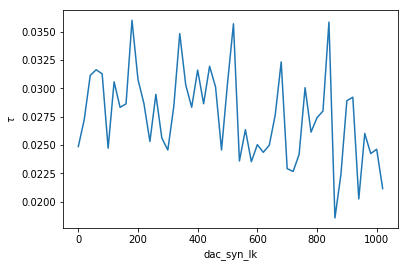

In [6]:
plt.figure()
plt.plot(lks, [r_i[0].x for r_i in r])
plt.xlabel("dac_syn_lk")
plt.ylabel(r"$\tau$")
plt.show()

assert np.all(r_i[0].success for r_i in r)